## Please provide your inputs as followed:

- **input_sdate**: The start date of your period of interest in the format **dd-mm-YYYY**
- **input_edate**: The end date of your period of interestin the format **dd-mm-YYYY**
- **geometry**: The region of interest. Please provide this in a **bounding box format** (e.g. [10, -5, 25, 20])

In [1]:
input_sdate = "2023 08 20"
input_edate = "2023 08 25"
geometry = [112.70505, -44.52755, 154.38241, -11.29524]

## Library imports 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import fsspec
import numpy as np
import xarray as xr
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time

## Starting up PySTAC client

In [3]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## User Input

### Processing of user input

In [4]:
# Function to convert date format 
def convert_format_date(input_date):
    date_obj = datetime.strptime(input_date, "%Y %m %d")
    formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date

# Convert user start date format
input_sdate = convert_format_date(input_sdate)

# Convert user end date format
input_edate = convert_format_date(input_edate)

date_period = input_sdate + "/" + input_edate 
date_period

'2023-08-20/2023-08-25'

## Search for product

In [31]:
search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    bbox = geometry,
    datetime=input_sdate + "/" + input_edate,
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = search.item_collection()

print(len(items))

20


## Process queried data into a dataset

In [6]:
# item_links = [item.assets['ch4'].href for item in items]
# item_links

# f = fsspec.open_files(item_links)
# f = [file.open() for file in f]


In [7]:
# ds = xr.open_mfdataset(f, group="PRODUCT", engine="h5netcdf", concat_dim='t', combine='nested') 
# ds

In [8]:
# varname = "methane_mixing_ratio_bias_corrected"
# data = ds[varname][0, :, :]
# vmin, vmax = np.nanpercentile(data, [1, 99])

# # methane product (NaN locations are transparent)
# lon = ds["longitude"].values.squeeze()
# lat = ds["latitude"].values.squeeze()
# methane = ds[varname].values.squeeze()

In [32]:
f1 = fsspec.open(items[0].assets['ch4'].href).open()
f1

<File-like object HTTPFileSystem, https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__CH4___/2023/08/25/S5P_OFFL_L2__CH4____20230825T063323_20230825T081453_30388_03_020500_20230826T222803/S5P_OFFL_L2__CH4____20230825T063323_20230825T081453_30388_03_020500_20230826T222803.nc?st=2023-09-25T05%3A42%3A37Z&se=2023-10-03T05%3A42%3A37Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-09-26T05%3A42%3A36Z&ske=2023-10-03T05%3A42%3A36Z&sks=b&skv=2021-06-08&sig=ISOKkw0XtM7CacCAlxY7UQnA/uH5o7psQkbtxSSPq1c%3D>

In [33]:
ds = xr.open_dataset(f1, group="PRODUCT", engine="h5netcdf") 
ds

<xarray.Dataset>
Dimensions:                              (scanline: 3735, ground_pixel: 215,
                                          time: 1, corner: 4, layer: 12,
                                          level: 13)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 3.734e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * time                                 (time) datetime64[ns] 2023-08-25
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
    latitude                             (time, scanline, ground_pixel) float32 ...
    longitude                            (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                           (time, scanline) datetime64[ns] ...
    time_utc                             (time, scanline) object ...
    qa_value                             (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 ...

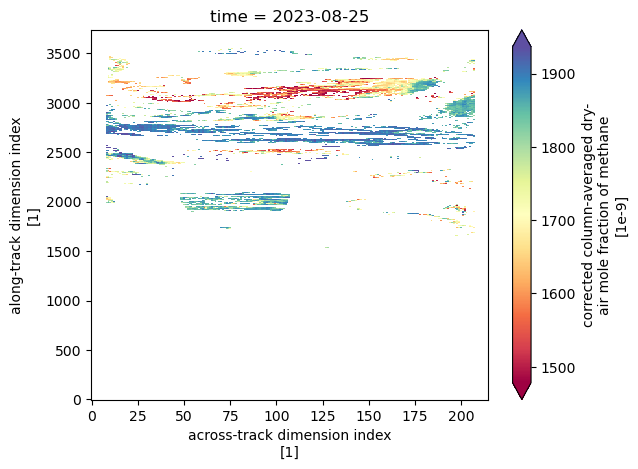

In [35]:
varname = "methane_mixing_ratio_bias_corrected"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="Spectral")

# methane product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
methane = data.values

In [36]:
methane.shape

(3735, 215)

## Plot Base Map & Concentration

/tmp/ipykernel_1418/2573924684.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset


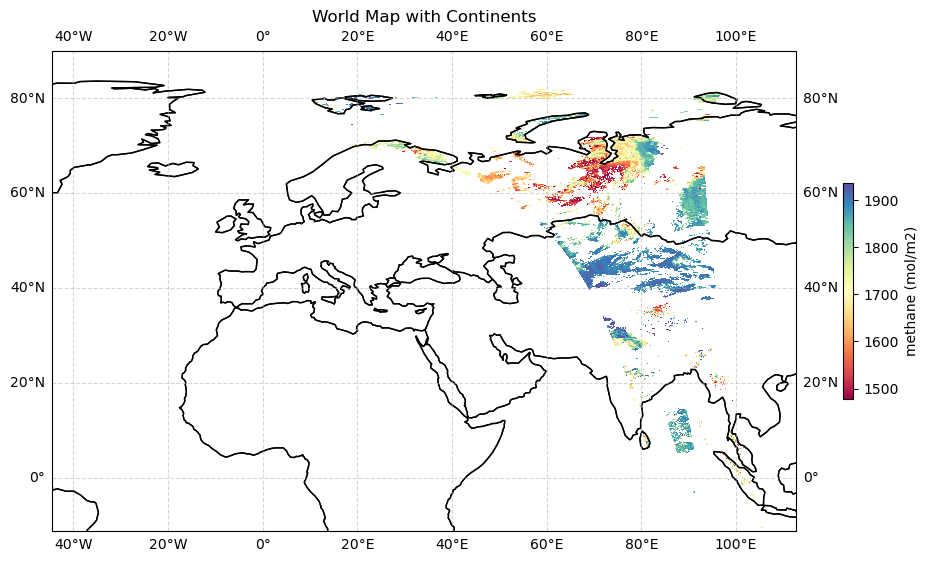

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset
continent_borders = world.dissolve(by='continent')

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')

ax.set_title("")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent(geometry, crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
colormesh = ax.pcolormesh (lon, lat, methane, cmap = "Spectral", norm = norm)
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")
plt.show()

## Plot concentration values